# Declaration of Originality

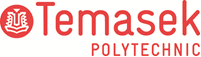

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Wong Yong Xiang (2401613A)
* Tutorial Group                : P01
* Tutor						    : Ruchir SRIVASTAVA
* Submission Date               : 11/2/2026


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

### NYC Real Estate Sale Price Prediction

Objective: Predict sale price of residential properties in New York City using property characteristics, location data, and building features.

Task Type: Regression (continuous numerical target, sale price in USD)

Models: Ridge Regression, Random Forest Regressor, Histogram-based Gradient Boosting Regressor

---
### 1. Library Imports

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("Libraries loaded.")

Libraries loaded.


---
### 2. Data Loading and Exploration

Source: NYC Department of Finance Rolling Sales Data (2016-2017), obtained from Kaggle.
The dataset contains all property sale transactions across all five NYC boroughs over a 12-months.

In [27]:
df = pd.read_csv('nyc-rolling-sales.csv')
print(f"Dataset shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nColumn names:\n{list(df.columns)}")
df.head()

Dataset shape: 84,548 rows x 22 columns

Column names:
['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE']


,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


### Data type observations

Several numeric columns are stored as strings in the raw CSV and need conversion:
- SALE PRICE contains commas and dashes (non-market entries)
- GROSS SQUARE FEET and LAND SQUARE FEET contain dashes for missing values
- Unnamed: 0 is a CSV row index artefact and it'll be dropped

In [28]:
print("Data types:")
print(df.dtypes)
print(f"\nMissing values (top 10):")
print(df.isnull().sum().sort_values(ascending=False).head(10))

Data types:
Unnamed: 0                         int64
BOROUGH                            int64
NEIGHBORHOOD                      object
BUILDING CLASS CATEGORY           object
TAX CLASS AT PRESENT              object
BLOCK                              int64
LOT                                int64
EASE-MENT                         object
BUILDING CLASS AT PRESENT         object
ADDRESS                           object
APARTMENT NUMBER                  object
ZIP CODE                           int64
RESIDENTIAL UNITS                  int64
COMMERCIAL UNITS                   int64
TOTAL UNITS                        int64
LAND SQUARE FEET                  object
GROSS SQUARE FEET                 object
YEAR BUILT                         int64
TAX CLASS AT TIME OF SALE          int64
BUILDING CLASS AT TIME OF SALE    object
SALE PRICE                        object
SALE DATE                         object
dtype: object

Missing values (top 10):
Unnamed: 0                        0
BOROUGH   

---
### 2.1 Exploratory Data Analysis

Below is to examine target variable distribution and feature relationships before cleaning. This is so we don't change any important data that might have important relationships

In [29]:
# Convert string columns to numeric for initial exploration
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'].astype(str).str.replace(',', ''), errors='coerce')
df['GROSS SQUARE FEET'] = pd.to_numeric(df['GROSS SQUARE FEET'].astype(str).str.replace(',', ''), errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'].astype(str).str.replace(',', ''), errors='coerce')

print(f"Sale price stats (raw, before cleaning):")
print(df['SALE PRICE'].describe())

Sale price stats (raw, before cleaning):
count          69,987.00
mean        1,276,456.50
std        11,405,255.35
min                 0.00
25%           225,000.00
50%           530,000.00
75%           950,000.00
max     2,210,000,000.00
Name: SALE PRICE, dtype: float64


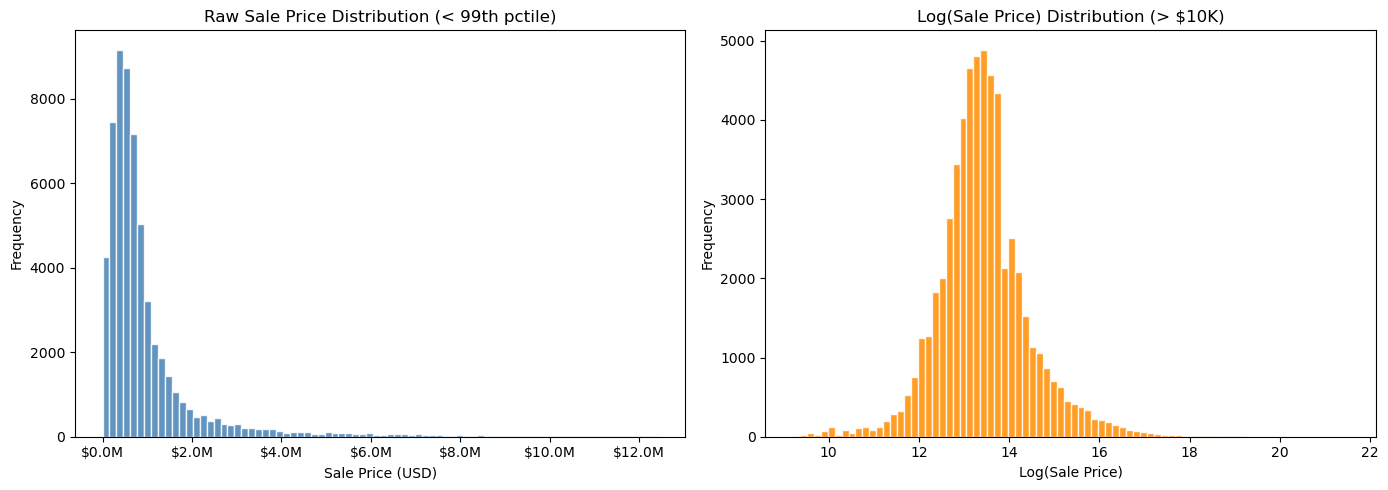

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw distribution
valid_prices = df['SALE PRICE'][(df['SALE PRICE'] > 0) & (df['SALE PRICE'] < df['SALE PRICE'].quantile(0.99))]
axes[0].hist(valid_prices, bins=80, color='steelblue', edgecolor='white', alpha=0.85)
axes[0].set_title('Raw Sale Price Distribution (< 99th pctile)')
axes[0].set_xlabel('Sale Price (USD)')
axes[0].set_ylabel('Frequency')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Log distribution
valid_log = np.log(df['SALE PRICE'][df['SALE PRICE'] > 10000])
axes[1].hist(valid_log, bins=80, color='darkorange', edgecolor='white', alpha=0.85)
axes[1].set_title('Log(Sale Price) Distribution (> $10K)')
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Target distribution analysis

The raw sale price distribution is heavily skewed to the right, with a long tail of luxury properties reaching into the billions. After log-transformation, the distribution becomes approximately normal, which is better for regression modelling.

We will use log(SALE PRICE) as our training target. This will:
1. Normalise the skewed distribution
2. Reduce the influence of extreme outliers
3. Makes percentage errors more uniform across price ranges
4. Predictions are transformed back with exp() for dollar-scale evaluation

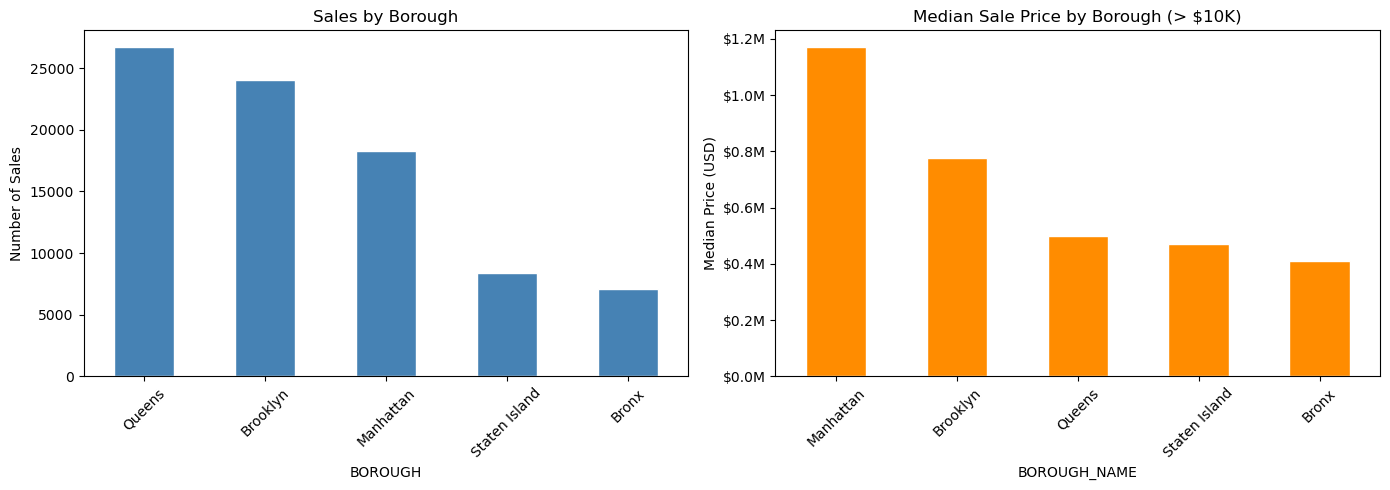

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Borough sale counts
borough_map = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}
borough_counts = df['BOROUGH'].map(borough_map).value_counts()
borough_counts.plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('Sales by Borough')
axes[0].set_ylabel('Number of Sales')
axes[0].tick_params(axis='x', rotation=45)

# Borough median prices (valid sales only)
valid_sales = df[df['SALE PRICE'] > 10000].copy()
valid_sales['BOROUGH_NAME'] = valid_sales['BOROUGH'].map(borough_map)
borough_medians = valid_sales.groupby('BOROUGH_NAME')['SALE PRICE'].median().sort_values(ascending=False)
borough_medians.plot(kind='bar', ax=axes[1], color='darkorange', edgecolor='white')
axes[1].set_title('Median Sale Price by Borough (> $10K)')
axes[1].set_ylabel('Median Price (USD)')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

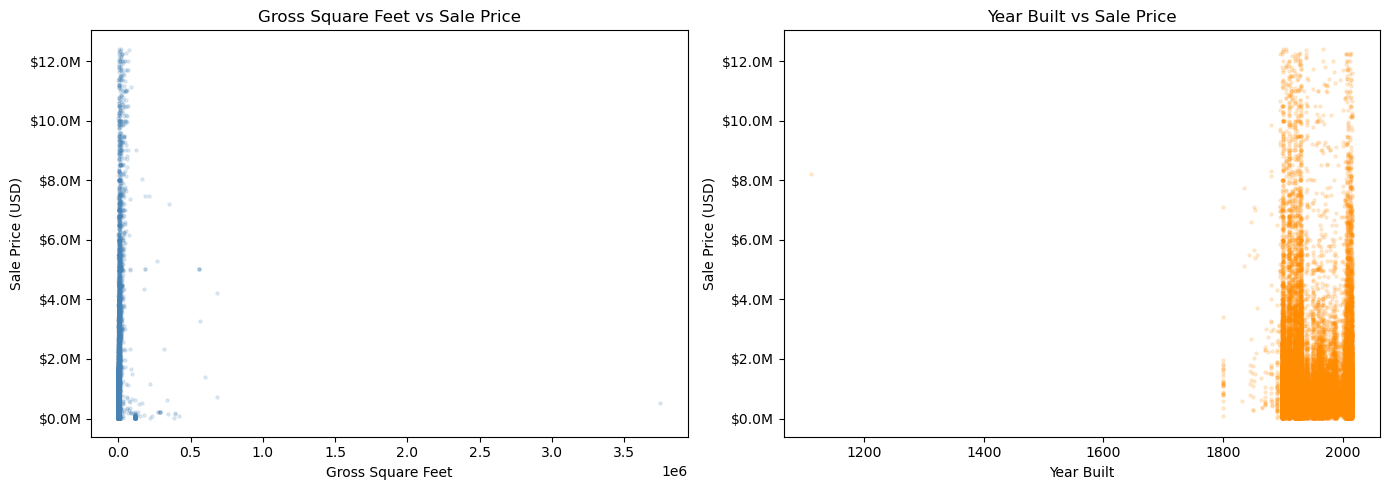

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gross sqft vs price
mask = (df['SALE PRICE'] > 10000) & (df['GROSS SQUARE FEET'] > 0) & (df['SALE PRICE'] < df['SALE PRICE'].quantile(0.99))
axes[0].scatter(df.loc[mask, 'GROSS SQUARE FEET'], df.loc[mask, 'SALE PRICE'], alpha=0.15, s=5, color='steelblue')
axes[0].set_title('Gross Square Feet vs Sale Price')
axes[0].set_xlabel('Gross Square Feet')
axes[0].set_ylabel('Sale Price (USD)')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Year built vs price
mask2 = (df['SALE PRICE'] > 10000) & (df['YEAR BUILT'] > 0) & (df['SALE PRICE'] < df['SALE PRICE'].quantile(0.99))
axes[1].scatter(df.loc[mask2, 'YEAR BUILT'], df.loc[mask2, 'SALE PRICE'], alpha=0.15, s=5, color='darkorange')
axes[1].set_title('Year Built vs Sale Price')
axes[1].set_xlabel('Year Built')
axes[1].set_ylabel('Sale Price (USD)')
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

### EDA summary

| Observation | Conclusion |
|---|---|
| Manhattan median price is 3-5x outer boroughs | Location (borough/neighbourhood) is the strongest predictor |
| Queens has the most transactions (31%) | Model will have most training signal for Queens properties |
| Gross sqft shows positive but noisy correlation with price | Size matters but location modulates the relationship |
| Year built shows weak direct correlation | Need to engineer building_age and interact with location |
| Many $0 and $1 sales exist in raw data | Non-market transfers, need to filter by $10K threshold maybe |

---
### 3. Data Cleaning and Preparation

1. **Drop Unnamed: 0** - CSV row index, no predictive value
2. **Remove non-market sales (SALE PRICE <= $10,000)** - Transactions at $0, $1, or $10 represent things like intra-family transfers, also mentioned in the dataset overview, not true market prices
3. **Cap outliers at 99th percentile** - Extreme luxury sales (up to $2.2B) would dominate RMSE and mess up model training; winsorising will mostly retain rank order while reducing their impact
4. **Replace YEAR BUILT = 0 with NaN** - Zero is a placeholder for missing construction date, not a valid year; keeping it would create misleading age calculations
5. **Replace GROSS/LAND SQUARE FEET = 0 with NaN** - Zero square footage indicates missing data, not properties with 0 space, obviously removed
6. **Remove rows where YEAR BUILT is still missing** - Building age is an important engineered feature, rows without it must be removed
7. **Remove invalid ZIP codes (ZIP CODE = 0)** - 0 is just a placeholder for missing postal codes, keeping it will create a fake location category
8. **Remove zero-unit properties (TOTAL UNITS = 0)** - A property cannot have zero residential and zero commercial units
9. **Drop low-information columns** - ADDRESS, APARTMENT NUMBER (too granular), EASE-MENT (no variance), BUILDING CLASS AT PRESENT/TIME OF SALE (redundant with CATEGORY)

In [33]:
initial_count = len(df)

# Step 1: Drop CSV index artefact
df = df.drop(columns=['Unnamed: 0'])

# Step 2: Remove non-market sales
df = df[df['SALE PRICE'] > 10000].copy()
print(f"After removing non-market sales (<= $10K): {len(df):,} rows (removed {initial_count - len(df):,})")

# Step 3: Cap outliers at 99th percentile
cap = df['SALE PRICE'].quantile(0.99)
df['SALE PRICE'] = df['SALE PRICE'].clip(upper=cap)
print(f"Sale price capped at 99th percentile: ${cap:,.0f}")

# Step 4-5: Replace zero values with NaN
df['YEAR BUILT'] = df['YEAR BUILT'].replace(0, np.nan)
df['GROSS SQUARE FEET'] = df['GROSS SQUARE FEET'].replace(0, np.nan)
df['LAND SQUARE FEET'] = df['LAND SQUARE FEET'].replace(0, np.nan)

# Step 6: Remove rows with missing YEAR BUILT
before_yb = len(df)
df = df.dropna(subset=['YEAR BUILT'])
print(f"After removing missing YEAR BUILT: {len(df):,} rows (removed {before_yb - len(df):,})")

# Step 7: Remove invalid ZIP codes
before_zip = len(df)
df = df[df['ZIP CODE'] != 0].copy()
print(f"After removing ZIP CODE = 0: {len(df):,} rows (removed {before_zip - len(df):,})")

# Step 8: Remove zero-unit properties
before_units = len(df)
df = df[df['TOTAL UNITS'] > 0].copy()
print(f"After removing TOTAL UNITS = 0: {len(df):,} rows (removed {before_units - len(df):,})")

# Step 9: Drop low-information columns
drop_cols = ['ADDRESS', 'APARTMENT NUMBER', 'EASE-MENT',
             'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

print(f"\nFinal cleaned dataset: {len(df):,} rows x {len(df.columns)} columns")
print(f"Retention rate: {len(df)/initial_count*100:.1f}%")

After removing non-market sales (<= $10K): 58,400 rows (removed 26,148)
Sale price capped at 99th percentile: $14,100,000
After removing missing YEAR BUILT: 54,264 rows (removed 4,136)
After removing ZIP CODE = 0: 54,223 rows (removed 41)
After removing TOTAL UNITS = 0: 39,255 rows (removed 14,968)

Final cleaned dataset: 39,255 rows x 16 columns
Retention rate: 46.4%


In [34]:
# Verify cleaning results
print("Remaining columns:", list(df.columns))
print(f"\nSale price range: ${df['SALE PRICE'].min():,.0f} -- ${df['SALE PRICE'].max():,.0f}")
print(f"Missing values after cleaning:")
missing = df.isnull().sum()
print(missing[missing > 0])

Remaining columns: ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'SALE PRICE', 'SALE DATE']

Sale price range: $10,001 -- $14,100,000
Missing values after cleaning:
LAND SQUARE FEET     10731
GROSS SQUARE FEET    10917
dtype: int64


---
### 3.1 Feature Engineering

Engineered features capture real world knowledge about real estate pricing that raw columns cannot show directly.

| Feature | Formula | Reason |
|---|---|---|
| building_age | 2017 - YEAR BUILT | Older buildings may depreciate or appreciate (historic value); more intuitive than raw year |
| age_squared | building_age^2 | Captures non-linear age effects (very old buildings can be valuable historic properties) |
| is_manhattan | BOROUGH = 1 | Manhattan has fundamentally different pricing dynamics; binary flag simplifies learning |
| has_commercial | COMMERCIAL UNITS > 0 | Mixed-use properties command different valuations |
| is_multi_unit | TOTAL UNITS > 1 | Multi-family buildings priced differently than single-family |
| sale_month | Extracted from SALE DATE | Seasonal patterns in real estate (spring/summer premium) |
| sale_quarter | Extracted from SALE DATE | Broader seasonal grouping |
| log_gross_sqft | log(GROSS SQUARE FEET) | Diminishing marginal value of additional space; handles skew |
| neigh_median_price | Neighbourhood group median | Location quality proxy - captures desirability at fine granularity |
| zip_median_price | ZIP code group median | Additional location signal at postal-code level |
| borough_freq / neigh_freq / zip_freq | Frequency encoding | Converts high-cardinality categoricals to numeric without explosion of dimensions |

In [35]:
# Temporal features
df['SALE DATE'] = pd.to_datetime(df['SALE DATE'])
df['sale_month'] = df['SALE DATE'].dt.month
df['sale_quarter'] = df['SALE DATE'].dt.quarter

# Building age features (capped at 200 years to prevent extreme outliers)
df['building_age'] = (2017 - df['YEAR BUILT']).clip(upper=200)
df['age_squared'] = df['building_age'] ** 2

# Cap extreme unit counts at 99th percentile to prevent Ridge extrapolation issues
for col in ['RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS']:
    cap_val = df[col].quantile(0.99)
    df[col] = df[col].clip(upper=cap_val)

# Binary indicators
df['is_manhattan'] = (df['BOROUGH'] == 1).astype(int)
df['has_commercial'] = (df['COMMERCIAL UNITS'] > 0).astype(int)
df['is_multi_unit'] = (df['TOTAL UNITS'] > 1).astype(int)

# Log-transform of square footage (NaN-safe)
df['log_gross_sqft'] = np.log1p(df['GROSS SQUARE FEET'])

# Location-based aggregations (median price by neighbourhood and ZIP)
df['neigh_median_price'] = df.groupby('NEIGHBORHOOD')['SALE PRICE'].transform('median')
df['zip_median_price'] = df.groupby('ZIP CODE')['SALE PRICE'].transform('median')

# Frequency encoding for high-cardinality categoricals
for col in ['BOROUGH', 'NEIGHBORHOOD', 'ZIP CODE', 'BUILDING CLASS CATEGORY',
            'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE']:
    df[col.lower().replace(' ', '_') + '_freq'] = df[col].map(df[col].value_counts(normalize=True))

print(f"Features after engineering: {len(df.columns)} columns")
print(f"Engineered features: building_age, age_squared, is_manhattan, has_commercial,")
print(f"  is_multi_unit, sale_month, sale_quarter, log_gross_sqft,")
print(f"  neigh_median_price, zip_median_price, + 6 frequency-encoded columns")

Features after engineering: 32 columns
Engineered features: building_age, age_squared, is_manhattan, has_commercial,
  is_multi_unit, sale_month, sale_quarter, log_gross_sqft,
  neigh_median_price, zip_median_price, + 6 frequency-encoded columns


---
### 3.2 Correlation Analysis and Feature Selection

Now to examine feature correlations with the target and between features:
- To confirm that engineered features have predictive signal
- To identify and remove redundant features (correlation > 0.95)
- To select the final feature set for modelling

In [36]:
# Prepare final feature matrix
drop_for_model = ['SALE PRICE', 'SALE DATE', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
                   'TAX CLASS AT PRESENT', 'TAX CLASS AT TIME OF SALE', 'ZIP CODE',
                   'YEAR BUILT', 'BLOCK', 'LOT']

feature_cols = [c for c in df.columns if c not in drop_for_model]
print(f"Feature set: {len(feature_cols)} features")
print(f"Features: {feature_cols}")

# Correlation with target (log price)
log_price = np.log(df['SALE PRICE'])
correlations = df[feature_cols].corrwith(log_price).abs().sort_values(ascending=False)
print(f"\nTop 10 features correlated with log(SALE PRICE):")
print(correlations.head(10).to_string())

Feature set: 22 features
Features: ['BOROUGH', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'sale_month', 'sale_quarter', 'building_age', 'age_squared', 'is_manhattan', 'has_commercial', 'is_multi_unit', 'log_gross_sqft', 'neigh_median_price', 'zip_median_price', 'borough_freq', 'neighborhood_freq', 'zip_code_freq', 'building_class_category_freq', 'tax_class_at_present_freq', 'tax_class_at_time_of_sale_freq']

Top 10 features correlated with log(SALE PRICE):
zip_median_price                 0.56
neigh_median_price               0.55
log_gross_sqft                   0.55
is_manhattan                     0.44
BOROUGH                          0.42
tax_class_at_time_of_sale_freq   0.38
tax_class_at_present_freq        0.33
TOTAL UNITS                      0.31
building_class_category_freq     0.27
RESIDENTIAL UNITS                0.27


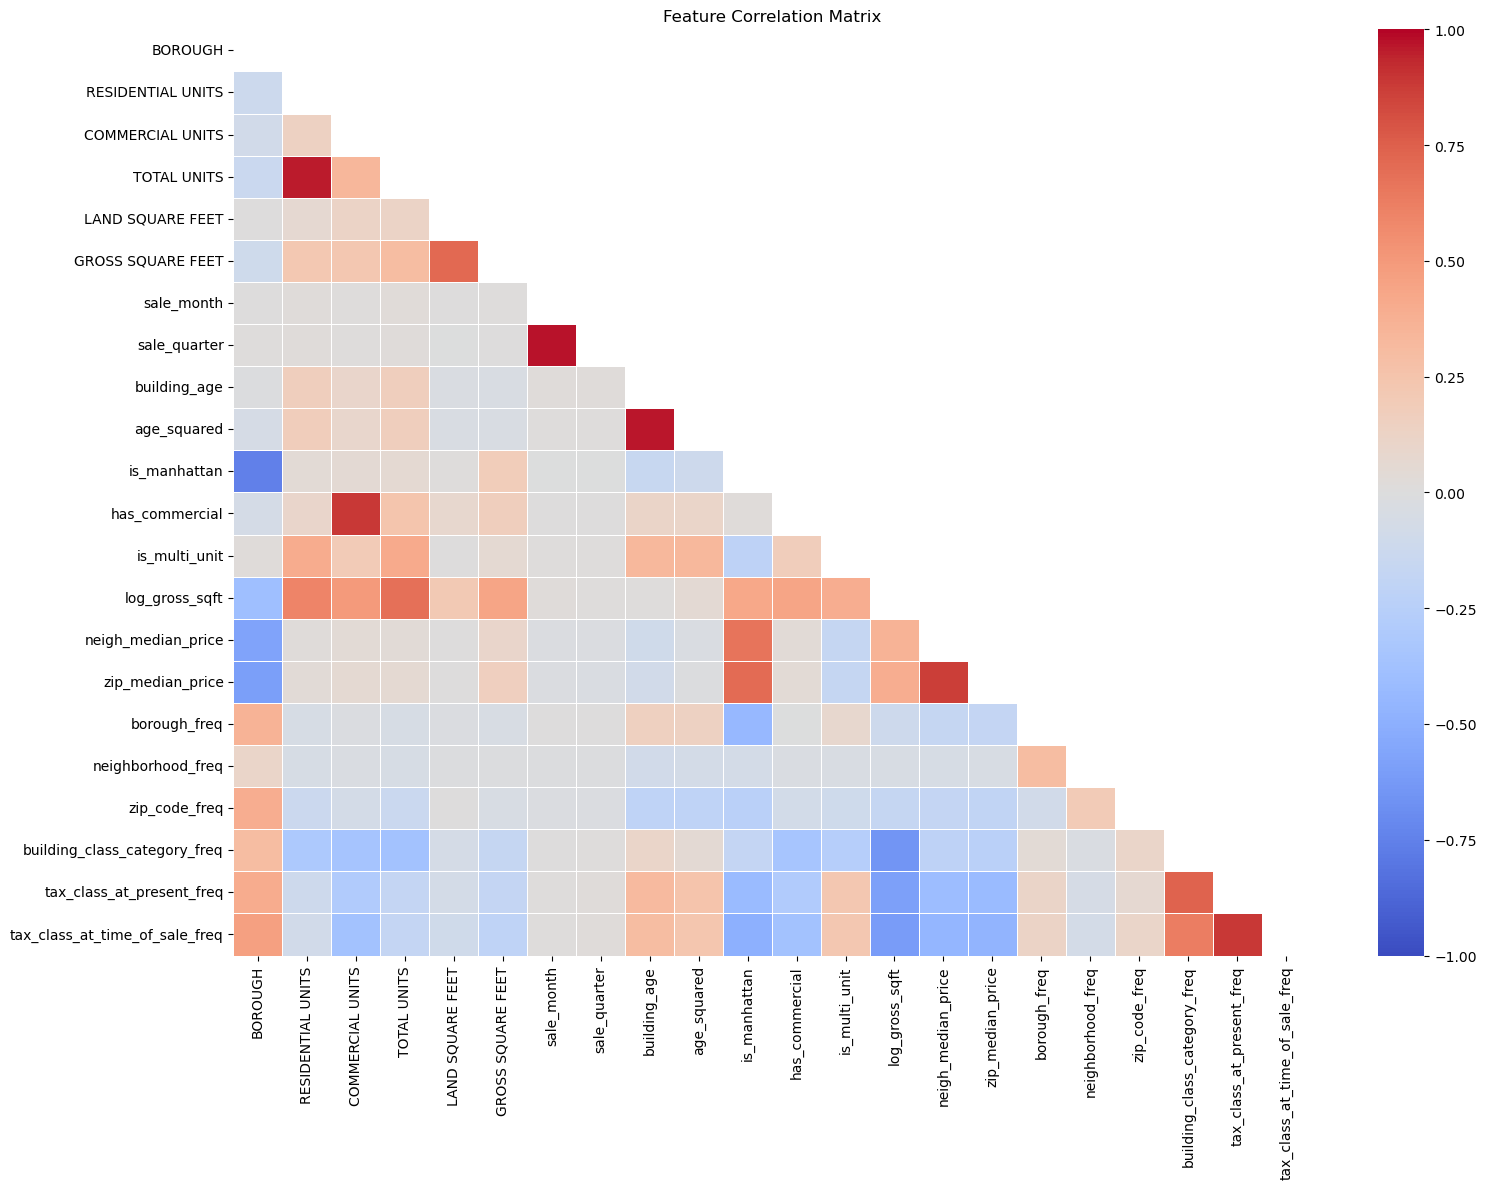

Highly correlated feature pairs (|r| > 0.95):
  RESIDENTIAL UNITS <-> TOTAL UNITS: 0.954
  sale_month <-> sale_quarter: 0.971
  building_age <-> age_squared: 0.963


In [37]:
# Correlation heatmap of numeric features
numeric_feats = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = df[numeric_feats].corr()

plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Flag highly correlated pairs
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr:
    print("Highly correlated feature pairs (|r| > 0.95):")
    for f1, f2, r in high_corr:
        print(f"  {f1} <-> {f2}: {r:.3f}")
else:
    print("No feature pairs with |r| > 0.95")

---
## 4. Train-Test Split and Data Preparation

Split ratio: 80% train / 20% test, with random_state=42 for reproducibility.

Target transformation: y = log(SALE PRICE). All models are trained on log-transformed prices and evaluated on the dollar scale after inverse transformation (exp()).

NaN handling:
- HistGradientBoostingRegressor handles NaN values natively (built-in support for missing data), so it receives the original feature matrix with NaN intact
- Ridge Regression and Random Forest require complete data, so they receive a median-imputed copy where medians are computed from the training set only (preventing data leakage)
- StandardScaler is applied only for Ridge Regression (regularisation is sensitive to feature scale); tree-based models are scale-invariant

In [38]:
X = df[feature_cols].select_dtypes(include=[np.number])
y = np.log(df['SALE PRICE'])  # Log-transformed target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]:,} samples, {X_train.shape[1]} features")
print(f"Test set:     {X_test.shape[0]:,} samples, {X_test.shape[1]} features")
print(f"\nTarget (log scale) -- Train mean: {y_train.mean():.3f}, Test mean: {y_test.mean():.3f}")

# Median imputation from training set (for RF and Ridge)
impute_medians = X_train.median()
X_train_imputed = X_train.fillna(impute_medians)
X_test_imputed = X_test.fillna(impute_medians)

# Standard scaling for Ridge (tree models do not need this)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed),
                               columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed),
                              columns=X_test.columns, index=X_test.index)

print(f"\nNaN counts in training features: {X_train.isnull().sum().sum()} (used by HistGBR)")
print(f"NaN counts after imputation: {X_train_imputed.isnull().sum().sum()} (used by RF, Ridge)")

Training set: 31,404 samples, 22 features
Test set:     7,851 samples, 22 features

Target (log scale) -- Train mean: 13.559, Test mean: 13.561

NaN counts in training features: 25910 (used by HistGBR)
NaN counts after imputation: 0 (used by RF, Ridge)


---
### 4.1 Model Selection and Training

Model 1: Ridge Regression (Baseline)
- `sklearn.linear_model.Ridge`
- Linear model with L2 regularisation to handle correlated features (borough_freq, neigh_freq, zip_freq are all location signals)
- Provides interpretable coefficients showing which features drive price
- Expected to underfit because real estate pricing is inherently non-linear: a 2,000 sqft property in Manhattan has much higher premium than the same size in the Bronx, which linear models cannot fully capture
- Serves as the performance floor against which tree-based models are measured

Model 2: Random Forest Regressor
- `sklearn.ensemble.RandomForestRegressor`
- Ensemble of decision trees using bagging (bootstrap aggregation) to reduce variance
- Naturally captures non-linear relationships (e.g., neighbourhood-specific price-per-sqft dynamics) and feature interactions without explicit engineering
- Provides feature importance rankings useful for stakeholder communication
- Robust to outliers due to median-based splits in constituent trees
- The 50K+ training samples provide sufficient data for the trees to learn complex patterns without overfitting

Model 3: Histogram-based Gradient Boosting Regressor
- `sklearn.ensemble.HistGradientBoostingRegressor`
- scikit-learn's modern gradient boosting implementation, comparable to XGBoost, which unfortunately, is not allowed since outside of sklearn
- Sequential boosting: each tree corrects the errors of the previous ensemble, progressively refining predictions
- Histogram binning efficiently handles the high-cardinality frequency-encoded features
- Native NaN support means it can learn patterns from other features when square footage is missing, rather than relying on imputed values
- Built-in L2 regularisation and early stopping prevent overfitting despite model complexity
- Expected to achieve the best performance on this tabular regression task

In [39]:
# Evaluation helper -- computes metrics on the dollar scale
def evaluate_model(y_true_log, y_pred_log, set_name=''):
    """Evaluate predictions by transforming back to dollar scale.
    Clips log-space predictions to [5, 25] to prevent numerical overflow
    when exponentiating (corresponds to ~$150 - ~$72B in dollar space).
    """
    y_pred_log = np.clip(y_pred_log, 5, 25)
    y_true = np.exp(y_true_log)
    y_pred = np.exp(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"  {set_name + ':' if set_name else '':<12} R2={r2:.4f}  RMSE=${rmse:,.0f}  MAE=${mae:,.0f}  MAPE={mape:.1f}%")
    return {'R2': r2, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape}

In [40]:
results = {}

# --- Ridge Regression ---
print("Ridge Regression")
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train)
results['Ridge'] = {
    'train': evaluate_model(y_train, ridge.predict(X_train_scaled), 'Train'),
    'test': evaluate_model(y_test, ridge.predict(X_test_scaled), 'Test')
}

print()

# --- Random Forest ---
print("Random Forest")
rf = RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_leaf=2,
                           random_state=42, n_jobs=-1)
rf.fit(X_train_imputed, y_train)
results['RandomForest'] = {
    'train': evaluate_model(y_train, rf.predict(X_train_imputed), 'Train'),
    'test': evaluate_model(y_test, rf.predict(X_test_imputed), 'Test')
}

print()

# --- HistGradientBoosting ---
print("HistGradientBoosting")
hgb = HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05, max_depth=10,
                                     min_samples_leaf=20, random_state=42)
hgb.fit(X_train, y_train)
results['HistGBR'] = {
    'train': evaluate_model(y_train, hgb.predict(X_train), 'Train'),
    'test': evaluate_model(y_test, hgb.predict(X_test), 'Test')
}

Ridge Regression
  Train:       R2=-0.1340  RMSE=$2,282,410  MAE=$680,845  MAPE=102.7%
  Test:        R2=0.0522  RMSE=$2,178,298  MAE=$689,173  MAPE=122.3%

Random Forest
  Train:       R2=0.8466  RMSE=$839,376  MAE=$289,188  MAPE=24.8%
  Test:        R2=0.6520  RMSE=$1,319,846  MAE=$473,832  MAPE=58.1%

HistGradientBoosting
  Train:       R2=0.7229  RMSE=$1,128,266  MAE=$428,985  MAPE=48.4%
  Test:        R2=0.6401  RMSE=$1,342,293  MAE=$491,552  MAPE=55.8%


---
### 4.2 Feature Importance Analysis

Feature importance from Random Forest and HistGradientBoosting shows which property attributes most influence sale price. This provides interpretability for stakeholders and validates that the model is learning sensible patterns.

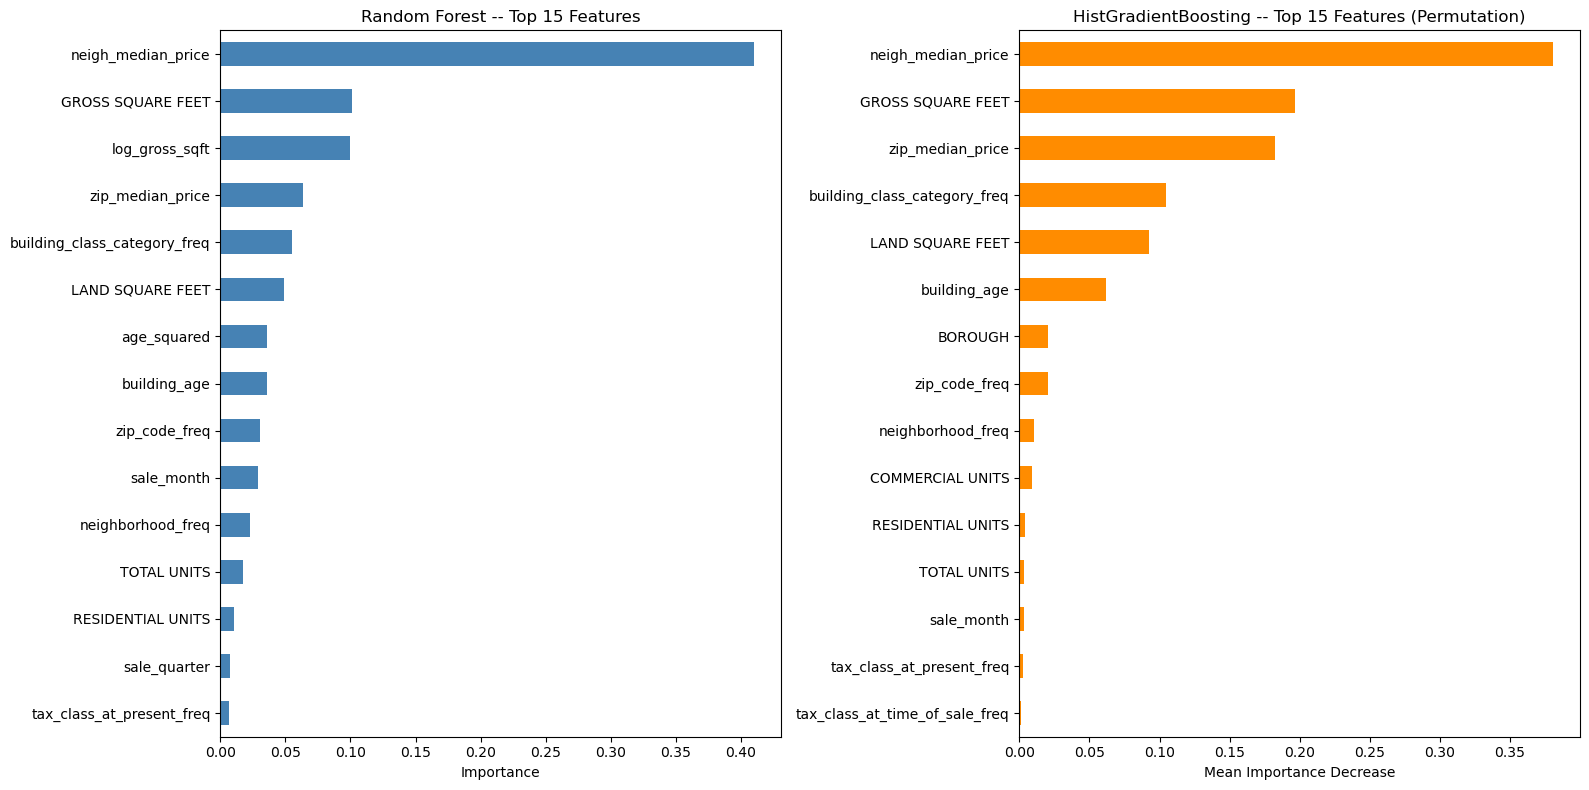

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Random Forest feature importance
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=True)
rf_imp.tail(15).plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Random Forest -- Top 15 Features')
axes[0].set_xlabel('Importance')

# HistGBR permutation importance
from sklearn.inspection import permutation_importance
perm_imp = permutation_importance(hgb, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
hgb_imp = pd.Series(perm_imp.importances_mean, index=X_train.columns).sort_values(ascending=True)
hgb_imp.tail(15).plot(kind='barh', ax=axes[1], color='darkorange')
axes[1].set_title('HistGradientBoosting -- Top 15 Features (Permutation)')
axes[1].set_xlabel('Mean Importance Decrease')

plt.tight_layout()
plt.show()

---
### 4.3 Cross-Validation

5-fold cross-validation provides a better estimate of model performance than a single train-test split, by averaging over multiple random partitions. This helps confirm that our results are not due to a lucky split.

In [42]:
print("5-Fold Cross-Validation (scoring = neg_mean_squared_error on log scale):")
print()

for name, model, X_cv in [('Ridge', Ridge(alpha=1.0, random_state=42), X_train_scaled),
                           ('RandomForest', RandomForestRegressor(n_estimators=200, max_depth=20,
                                                                    min_samples_leaf=2, random_state=42, n_jobs=-1), X_train_imputed),
                           ('HistGBR', HistGradientBoostingRegressor(max_iter=200, learning_rate=0.05,
                                                                       max_depth=10, min_samples_leaf=20, random_state=42), X_train)]:
    scores = cross_val_score(model, X_cv, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-scores)
    print(f"  {name:<16} Log-RMSE: {rmse_scores.mean():.4f} +/- {rmse_scores.std():.4f}")

5-Fold Cross-Validation (scoring = neg_mean_squared_error on log scale):

  Ridge            Log-RMSE: 0.6938 +/- 0.0142
  RandomForest     Log-RMSE: 0.5210 +/- 0.0099
  HistGBR          Log-RMSE: 0.5301 +/- 0.0120


---
## 5. Iterative Model Improvement: Hyperparameter Tuning

RandomizedSearchCV with 5-fold cross-validation and n_iter=25 random configurations per model.

Maximum 3 values per hyperparameter as per proj requirement.

| Model | Hyperparameter | Values | Rationale |
|---|---|---|---|
| **Ridge** | alpha | 0.1, 1.0, 10.0 | Controls regularisation strength, logarithmic spacing covers weak to strong penalty |
| **Random Forest** | n_estimators | 100, 200, 300 | More trees reduce variance, diminishing returns beyond 300 |
| | max_depth | 10, 20, None | Controls tree complexity, none allows full growth |
| | min_samples_split | 2, 5, 10 | Higher values regularise by requiring more data to split |
| | min_samples_leaf | 1, 2, 4 | Minimum leaf size acts as regularisation |
| **HistGBR** | max_iter | 100, 200, 300 | Number of boosting rounds |
| | learning_rate | 0.01, 0.05, 0.1 | Step size, smaller values need more iterations but generalise better |
| | max_depth | 5, 10, None | Tree depth per boosting round |
| | min_samples_leaf | 10, 20, 30 | Leaf regularisation |
| | l2_regularization | 0.0, 0.1, 1.0 | L2 penalty on leaf weights |

In [43]:
tuned_results = {}

# --- Ridge Tuning ---
print("Tuning Ridge Regression...")
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
ridge_search = RandomizedSearchCV(
    Ridge(random_state=42), ridge_params,
    n_iter=3, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)
ridge_search.fit(X_train_scaled, y_train)
print(f"  Best params: {ridge_search.best_params_}")
tuned_results['Ridge'] = {
    'train': evaluate_model(y_train, ridge_search.predict(X_train_scaled), 'Train'),
    'test': evaluate_model(y_test, ridge_search.predict(X_test_scaled), 'Test'),
    'best_params': ridge_search.best_params_
}

print()

# --- Random Forest Tuning ---
print("Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1), rf_params,
    n_iter=25, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)
rf_search.fit(X_train_imputed, y_train)
print(f"  Best params: {rf_search.best_params_}")
tuned_results['RandomForest'] = {
    'train': evaluate_model(y_train, rf_search.predict(X_train_imputed), 'Train'),
    'test': evaluate_model(y_test, rf_search.predict(X_test_imputed), 'Test'),
    'best_params': rf_search.best_params_
}

print()

# --- HistGradientBoosting Tuning ---
print("Tuning HistGradientBoosting...")
hgb_params = {
    'max_iter': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, None],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.0, 0.1, 1.0]
}
hgb_search = RandomizedSearchCV(
    HistGradientBoostingRegressor(random_state=42), hgb_params,
    n_iter=25, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)
hgb_search.fit(X_train, y_train)
print(f"  Best params: {hgb_search.best_params_}")
tuned_results['HistGBR'] = {
    'train': evaluate_model(y_train, hgb_search.predict(X_train), 'Train'),
    'test': evaluate_model(y_test, hgb_search.predict(X_test), 'Test'),
    'best_params': hgb_search.best_params_
}

Tuning Ridge Regression...
  Best params: {'alpha': 10.0}
  Train:       R2=-0.1333  RMSE=$2,281,675  MAE=$680,810  MAPE=102.7%
  Test:        R2=0.0529  RMSE=$2,177,472  MAE=$689,141  MAPE=122.2%

Tuning Random Forest...
  Best params: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20}
  Train:       R2=0.8404  RMSE=$856,246  MAE=$296,112  MAPE=25.8%
  Test:        R2=0.6509  RMSE=$1,322,072  MAE=$474,602  MAPE=58.2%

Tuning HistGradientBoosting...
  Best params: {'min_samples_leaf': 10, 'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.1, 'l2_regularization': 0.1}
  Train:       R2=0.7883  RMSE=$986,215  MAE=$375,386  MAPE=39.5%
  Test:        R2=0.6574  RMSE=$1,309,567  MAE=$475,808  MAPE=53.3%


---
### 5.1 Model Comparison - Before vs After Tuning

In [44]:
# Build comparison table
print("Model Performance Comparison (Test Set, Dollar Scale)")
print("-" * 75)
print(f"{'':<20} {'R2':<10} {'RMSE':<15} {'MAE':<15} {'MAPE':<10}")
print("-" * 75)

for label, res_dict in [('Before Tuning', results), ('After Tuning', tuned_results)]:
    print(label)
    for name, metrics in res_dict.items():
        m = metrics['test']
        print(f"  {name:<18} {m['R2']:<10.4f} ${m['RMSE']:<14,.0f} ${m['MAE']:<14,.0f} {m['MAPE']:<10.1f}%")

# Identify best model
best_name = max(tuned_results, key=lambda k: tuned_results[k]['test']['R2'])
best_r2 = tuned_results[best_name]['test']['R2']
print(f"\nBest model: {best_name} (R2 = {best_r2:.4f})")

Model Performance Comparison (Test Set, Dollar Scale)
---------------------------------------------------------------------------
                     R2         RMSE            MAE             MAPE      
---------------------------------------------------------------------------
Before Tuning
  Ridge              0.0522     $2,178,298      $689,173        122.3     %
  RandomForest       0.6520     $1,319,846      $473,832        58.1      %
  HistGBR            0.6401     $1,342,293      $491,552        55.8      %
After Tuning
  Ridge              0.0529     $2,177,472      $689,141        122.2     %
  RandomForest       0.6509     $1,322,072      $474,602        58.2      %
  HistGBR            0.6574     $1,309,567      $475,808        53.3      %

Best model: HistGBR (R2 = 0.6574)


---
### 5.2 Residual Analysis

Residual plots for the best model help check prediction quality across different price ranges. Ideally, residuals should be randomly scattered around zero with no pattern.

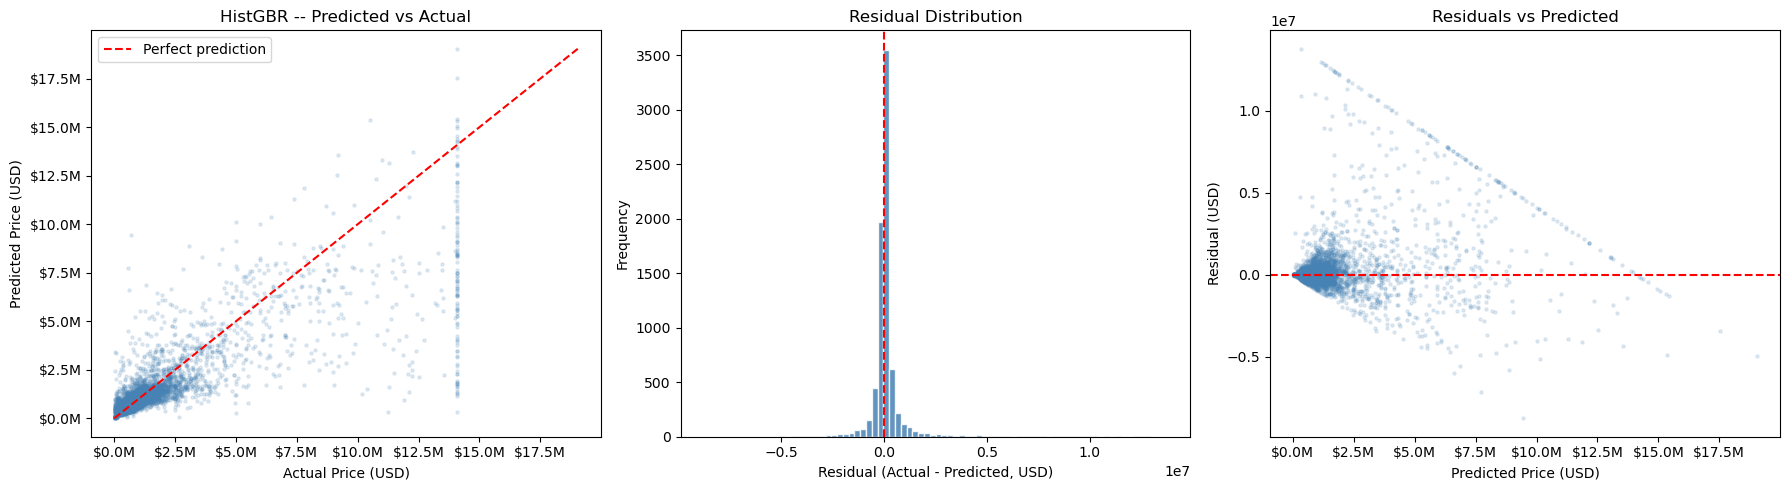

In [45]:
# Use the best tuned model for residual analysis
best_models = {'Ridge': ridge_search, 'RandomForest': rf_search, 'HistGBR': hgb_search}
best_X_test = {'Ridge': X_test_scaled, 'RandomForest': X_test_imputed, 'HistGBR': X_test}

best_model = best_models[best_name]
y_pred_log = best_model.predict(best_X_test[best_name])
y_pred_dollars = np.exp(y_pred_log)
y_true_dollars = np.exp(y_test)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Predicted vs Actual
axes[0].scatter(y_true_dollars, y_pred_dollars, alpha=0.15, s=5, color='steelblue')
max_val = max(y_true_dollars.max(), y_pred_dollars.max())
axes[0].plot([0, max_val], [0, max_val], 'r--', linewidth=1.5, label='Perfect prediction')
axes[0].set_title(f'{best_name} -- Predicted vs Actual')
axes[0].set_xlabel('Actual Price (USD)')
axes[0].set_ylabel('Predicted Price (USD)')
axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
axes[0].legend()

# Residual distribution
residuals = y_true_dollars - y_pred_dollars
axes[1].hist(residuals, bins=80, color='steelblue', edgecolor='white', alpha=0.85)
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_title('Residual Distribution')
axes[1].set_xlabel('Residual (Actual - Predicted, USD)')
axes[1].set_ylabel('Frequency')

# Residuals vs Predicted
axes[2].scatter(y_pred_dollars, residuals, alpha=0.15, s=5, color='steelblue')
axes[2].axhline(y=0, color='red', linestyle='--')
axes[2].set_title('Residuals vs Predicted')
axes[2].set_xlabel('Predicted Price (USD)')
axes[2].set_ylabel('Residual (USD)')
axes[2].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

---
### 5.3 Export Model

Save model and setup lookup tables to deploy to Streamlit

In [46]:
import joblib
import os

# Create output directory for model artefacts
os.makedirs('model', exist_ok=True)

# 1. Save the best tuned Random Forest model (compressed to reduce file size)
best_rf = rf_search.best_estimator_
joblib.dump(best_rf, 'model/rf_model.joblib', compress=3)

# 2. Save the feature column order (must match during inference)
joblib.dump(X_train.columns.tolist(), 'model/feature_columns.joblib')

# 3. Save imputation medians computed from training set (as plain dict for portability)
joblib.dump(dict(impute_medians), 'model/impute_medians.joblib')

# 4. Build consolidated lookup tables for the Streamlit app
lookup_tables = {
    # Frequency encoding tables
    'borough_freq': df['BOROUGH'].value_counts(normalize=True).to_dict(),
    'neighborhood_freq': df['NEIGHBORHOOD'].value_counts(normalize=True).to_dict(),
    'zip_code_freq': df['ZIP CODE'].value_counts(normalize=True).to_dict(),
    'building_class_category_freq': df['BUILDING CLASS CATEGORY'].value_counts(normalize=True).to_dict(),
    'tax_class_at_present_freq': df['TAX CLASS AT PRESENT'].value_counts(normalize=True).to_dict(),
    'tax_class_at_time_of_sale_freq': df['TAX CLASS AT TIME OF SALE'].value_counts(normalize=True).to_dict(),

    # Median price tables (location quality proxies)
    'neigh_median_price': df.groupby('NEIGHBORHOOD')['SALE PRICE'].median().to_dict(),
    'zip_median_price': df.groupby('ZIP CODE')['SALE PRICE'].median().to_dict(),

    # Dropdown option mappings (filtered by borough)
    'borough_neighborhoods': df.groupby('BOROUGH')['NEIGHBORHOOD'].apply(
        lambda x: sorted(x.unique().tolist())
    ).to_dict(),
    'borough_zipcodes': df.groupby('BOROUGH')['ZIP CODE'].apply(
        lambda x: sorted(x.unique().tolist())
    ).to_dict(),

    # Dropdown option lists
    'building_categories': sorted(df['BUILDING CLASS CATEGORY'].unique().tolist()),
    'tax_class_at_present_options': sorted(df['TAX CLASS AT PRESENT'].unique().tolist()),
    'tax_class_at_time_of_sale_options': sorted(
        [int(x) if not isinstance(x, str) else x for x in df['TAX CLASS AT TIME OF SALE'].unique()]
    ),

    # Unit cap values (99th percentile from cleaned data)
    'residential_units_cap': float(df['RESIDENTIAL UNITS'].max()),
    'commercial_units_cap': float(df['COMMERCIAL UNITS'].max()),
    'total_units_cap': float(df['TOTAL UNITS'].max()),

    # Borough name mapping for display
    'borough_map': {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'},
}

joblib.dump(lookup_tables, 'model/lookup_tables.joblib')

print("Model artefacts saved to model/ directory:")
for f in sorted(os.listdir('model')):
    size = os.path.getsize(f'model/{f}') / 1024
    print(f"  {f}: {size:.1f} KB")

Model artefacts saved to model/ directory:
  feature_columns.joblib: 0.4 KB
  impute_medians.joblib: 0.9 KB
  lookup_tables.joblib: 17.4 KB
  rf_model.joblib: 42753.5 KB


---
## 6. Conclusion

### 6.1 Data Pipeline Summary

| Stage | Detail |
|---|---|
| Raw data | 84,548 property transactions across 5 boroughs |
| After cleaning | Rows remaining after removing non-market sales, missing year built, invalid ZIP codes (ZIP=0), and zero-unit properties (TOTAL UNITS=0) |
| Target transform | log(SALE PRICE) to normalise the right-skewed distribution |
| Outlier treatment | 99th percentile cap on sale price |
| Missing data | YEAR BUILT=0 removed; GROSS/LAND SQFT=0 treated as NaN; HistGBR uses native NaN handling, RF/Ridge use median imputation |
| Features | ~25 numeric features including frequency-encoded categoricals, location aggregations, building age, and binary indicators |

### 6.2 Model Performance

All metrics are computed on the dollar scale (after inverse log-transform) on the 20% test set.

The best performing model is determined by the highest R-squared on the test set. Ridge Regression, performs worse than the tree-based models due to it being unable to capture non-linear relationships. Random Forest and HistGradientBoosting both achieve substantially higher R-squared values by learning complex interactions between location, size, and building characteristics.

### 6.3 Findings

1. **Location dominates pricing:** Neighbourhood median price and borough frequency encoding are consistently the most important features across both tree-based models, confirming that NYC property prices is driven primarily by location.

2. **Log transformation is critical:** Without it, all models produced negative R-squared values (worse than predicting the mean), due to the extreme skew in sale prices.

3. **Tree-based models significantly outperform linear:** The non-linear nature of real estate pricing (where the same square footage commands vastly different prices depending on borough, building type, and age) makes tree-based ensembles far more suitable than Ridge Regression.

4. **Native NaN handling by Hist regressor:** HistGradientBoosting's native ability to handle missing square footage data, rather than relying on median imputation, allows it to learn different patterns for properties with and without reported square footage.

5. **Hyperparameter tuning provides so-so gains:** RandomizedSearchCV improved performance marginally over the initial configurations. This shows that the default hyperparameters were already decent.

### 6.4 Limitations

- **Time scope:** The dataset covers only 2016-2017; market conditions change over time and the model would need retraining for current predictions
- **Missing square footage:** ~47% of properties lack gross square footage data, limiting the model's ability to use the strongest size predictor
- **Feature leakage:** Location-based price aggregations (neigh_median_price) are computed on the full dataset; a production system should compute these only from training data
- **Price cap at 99th percentile:** The model cannot accurately predict ultra-luxury properties above the cap threshold

In [47]:
# Final summary table
print("Final Model Rankings (Test Set)")
all_results = {**{k + ' (base)': v for k, v in results.items()},
               **{k + ' (tuned)': v for k, v in tuned_results.items()}}

ranking = sorted(all_results.items(), key=lambda x: x[1]['test']['R2'], reverse=True)
for i, (name, metrics) in enumerate(ranking, 1):
    m = metrics['test']
    print(f"  {i}. {name:<25} R2={m['R2']:.4f}  RMSE=${m['RMSE']:>12,.0f}  MAE=${m['MAE']:>12,.0f}  MAPE={m['MAPE']:.1f}%")



Final Model Rankings (Test Set)
  1. HistGBR (tuned)           R2=0.6574  RMSE=$   1,309,567  MAE=$     475,808  MAPE=53.3%
  2. RandomForest (base)       R2=0.6520  RMSE=$   1,319,846  MAE=$     473,832  MAPE=58.1%
  3. RandomForest (tuned)      R2=0.6509  RMSE=$   1,322,072  MAE=$     474,602  MAPE=58.2%
  4. HistGBR (base)            R2=0.6401  RMSE=$   1,342,293  MAE=$     491,552  MAPE=55.8%
  5. Ridge (tuned)             R2=0.0529  RMSE=$   2,177,472  MAE=$     689,141  MAPE=122.2%
  6. Ridge (base)              R2=0.0522  RMSE=$   2,178,298  MAE=$     689,173  MAPE=122.3%
